# Plots

This file provides plots for different results.

# Gurobi - Computing Time according to Sigma and Cardinality Constraint

### Indtrack

The datasets used are indtrack. They all have 290 rows, but various number of columns, ranging from 33 to 2153. Sheets/Gurobi.xlsx is used, and "0,01_le sheet"

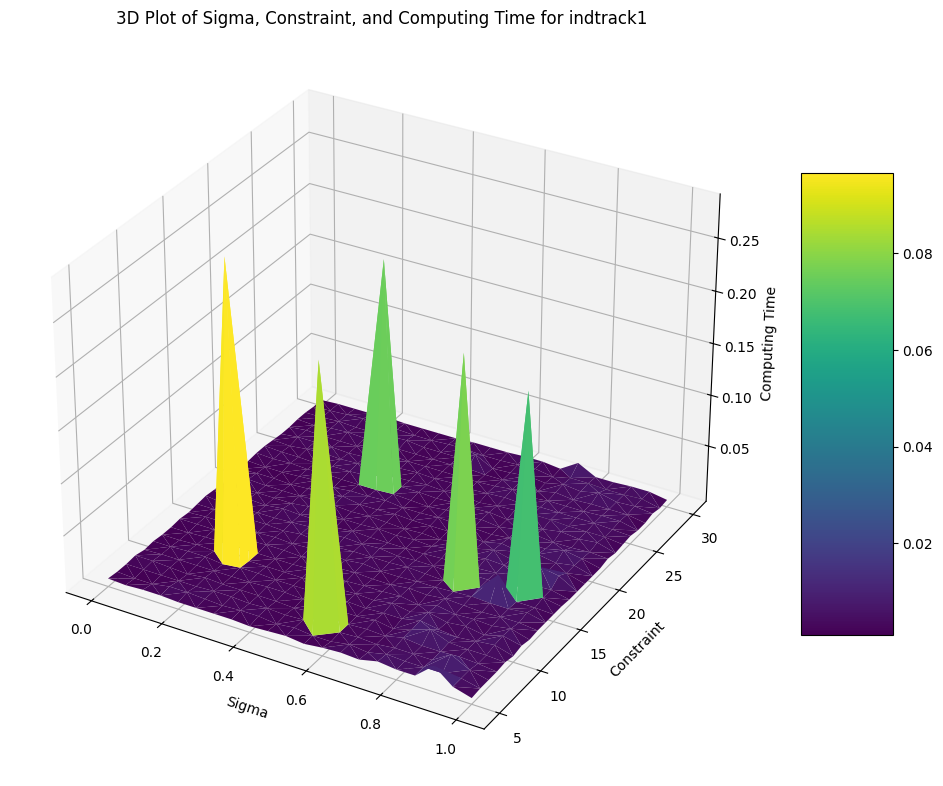

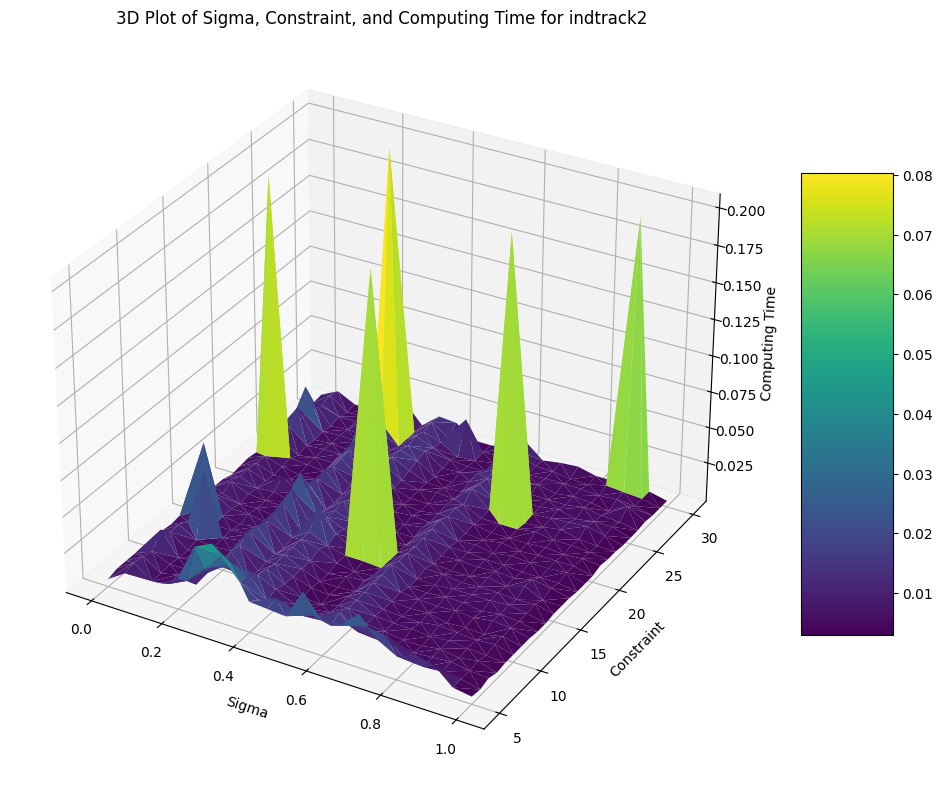

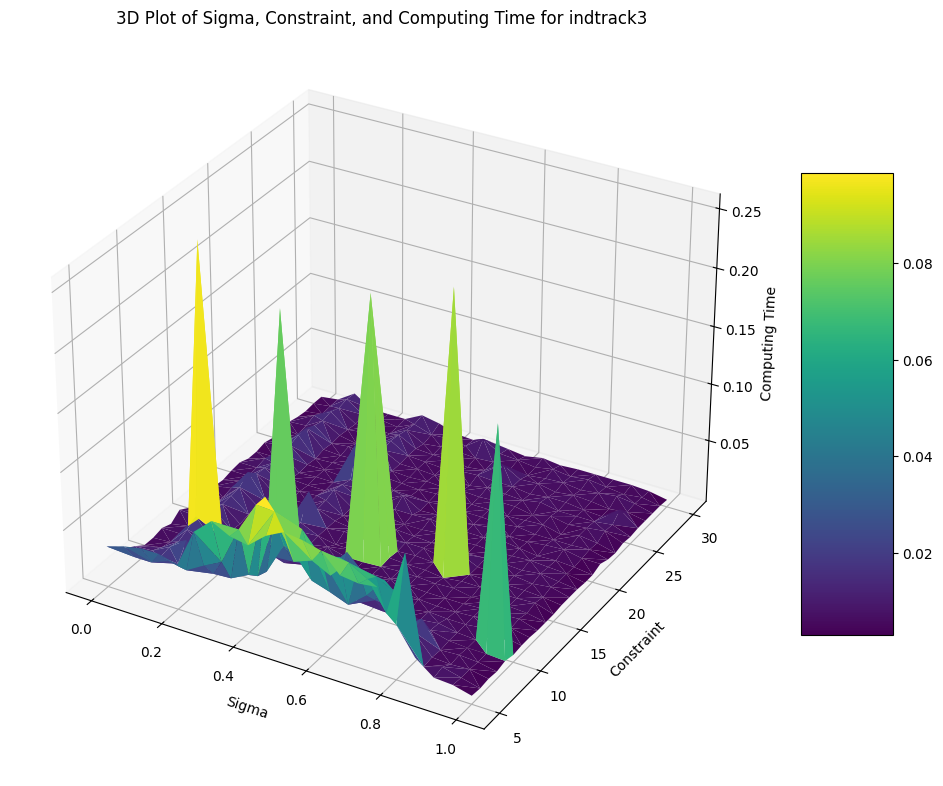

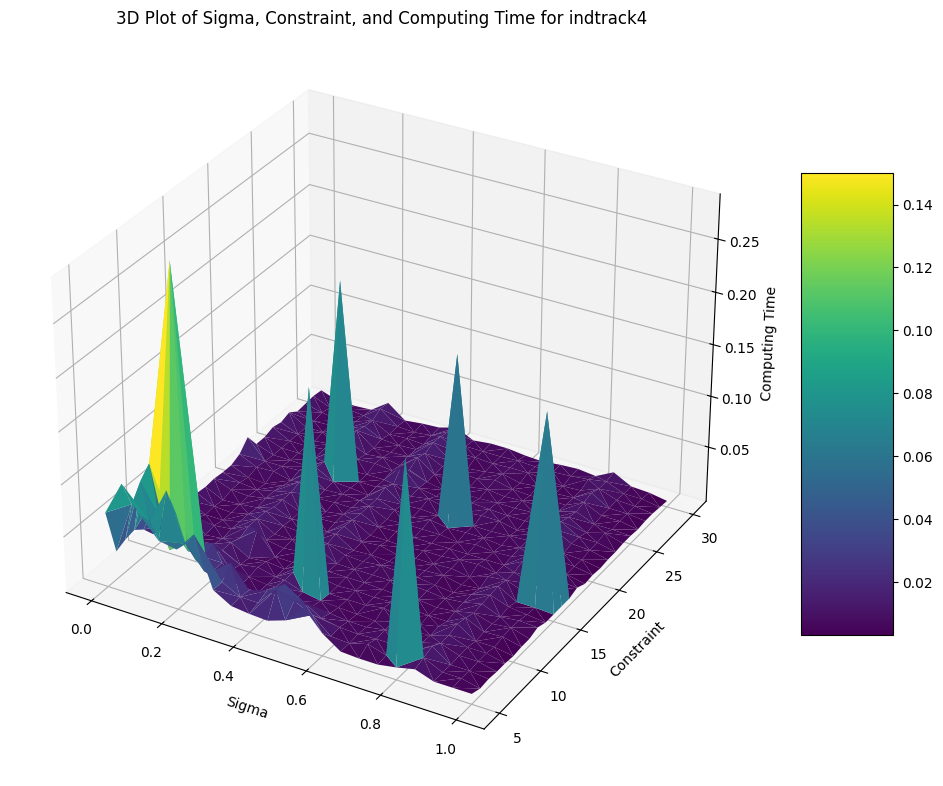

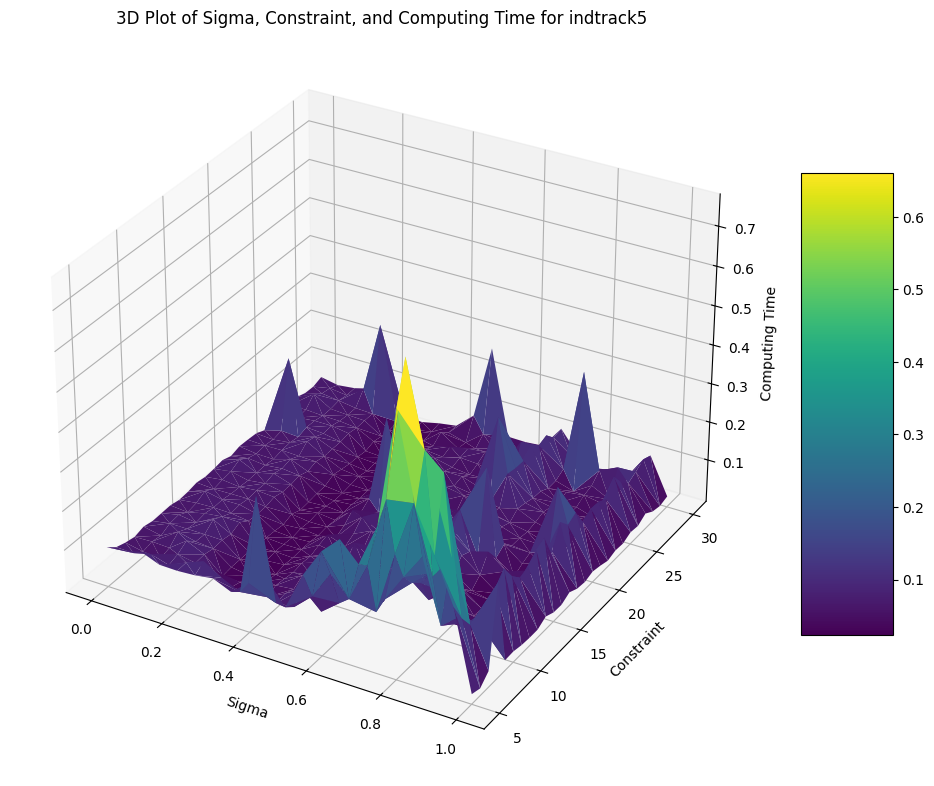

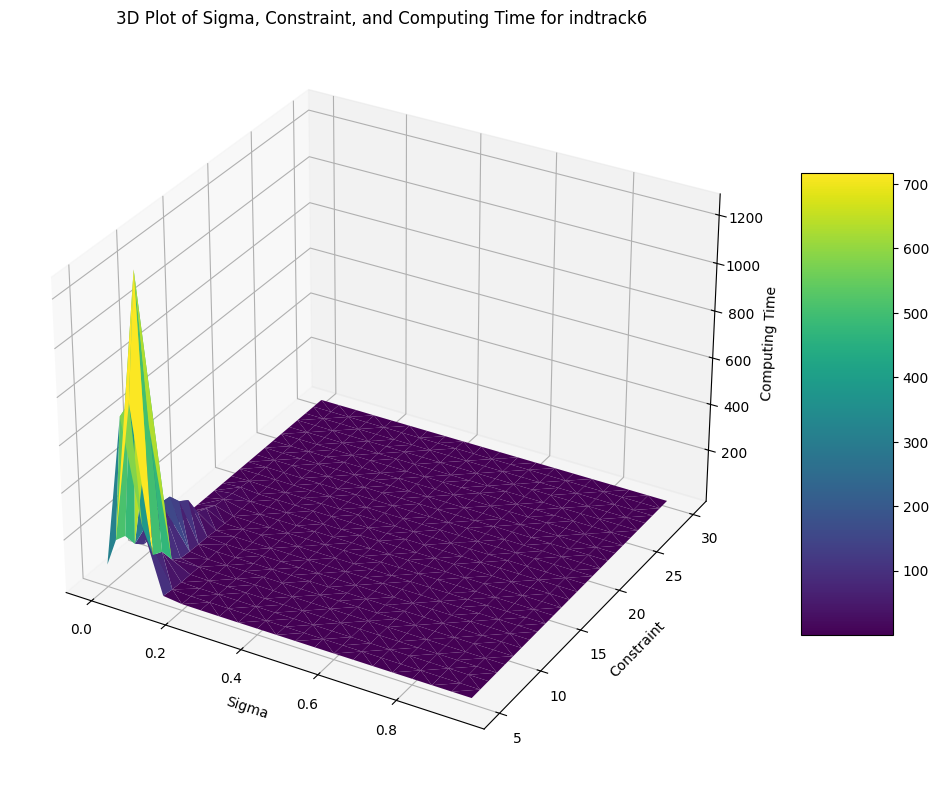

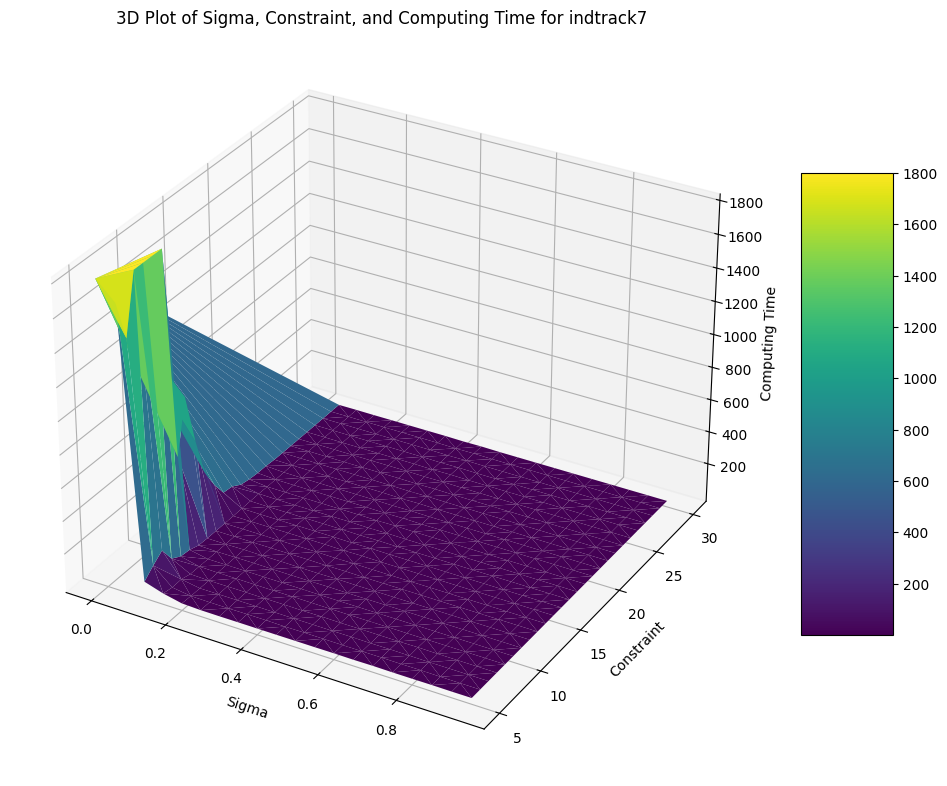

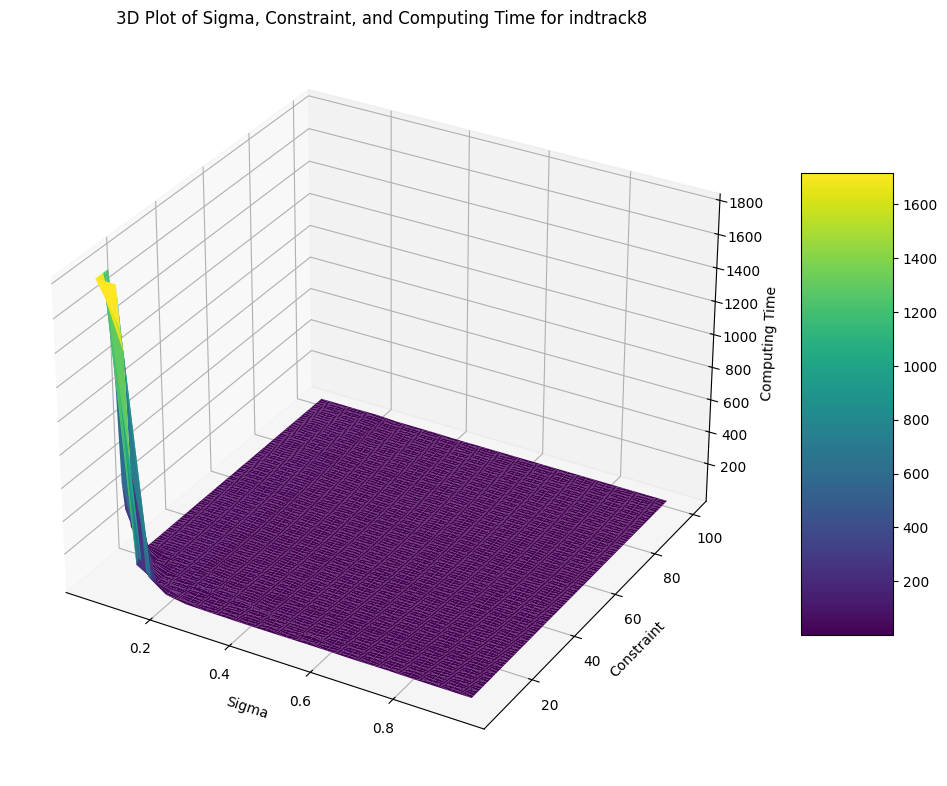

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

file_path = "Sheets/Gurobi.xlsx"

df = pd.read_excel(file_path, "0,01_le")


for indtrack in range(1, 9):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')


    df_track = df[df['Data'] == f"indtrack{indtrack}.txt"]
    x = df_track['Sigma']
    y = df_track['Cardinality Constraint']
    z = df_track['Solution Time']
    
    surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


    ax.set_xlabel('Sigma')
    ax.set_ylabel('Constraint')
    ax.set_zlabel('Computing Time')

    ax.set_title(f'3D Plot of Sigma, Constraint, and Computing Time for indtrack{indtrack}')
    fig.savefig(f'Plots/Gurobi_plots/indtrack{indtrack}_bis.png')

plt.show()


For indtrack1 to indtrack5, we are working with small datasets, and the computing time is the same, regarding Sigma or the Constraint.

For indtrack6 to indtack8, for small values of sigma and small constraint, we can see that Gurobi struggles to get a optimal solution quickly.

However, when we look at [this Jupyter Notebook](SSP_with_other_data.ipynb), we can see that the computing time is also very long when Sigma = 0.5 (or even Sigma = 0.05). This might show that the computing time also depends on the number of rows, or the dataset itself. 

# Barplot - Comparison between different Cardinality Constraints modes & Models

Here, we will try to average the optimal value for each Cardinality Constraints modes, and then compare them on indtrack7. (1 mode = 1 sheet in this case)
The models have been trained for around 30 min on indtrack7, with the exception of "Transfert" (df11) which have been trained for around 30 min on indtrack8 and for around 10min on indtrack7.

However, the average is not done totally fairly, as some datasets have very little datapoints (Kernel_S_return only has 2 rows, due to obvious bad results).

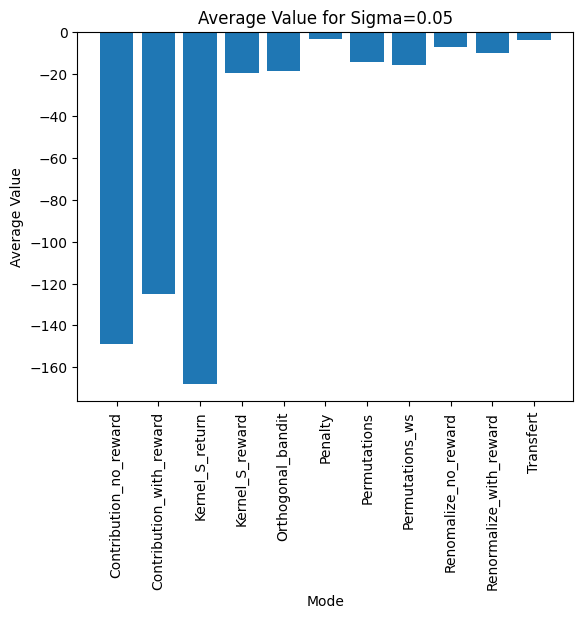

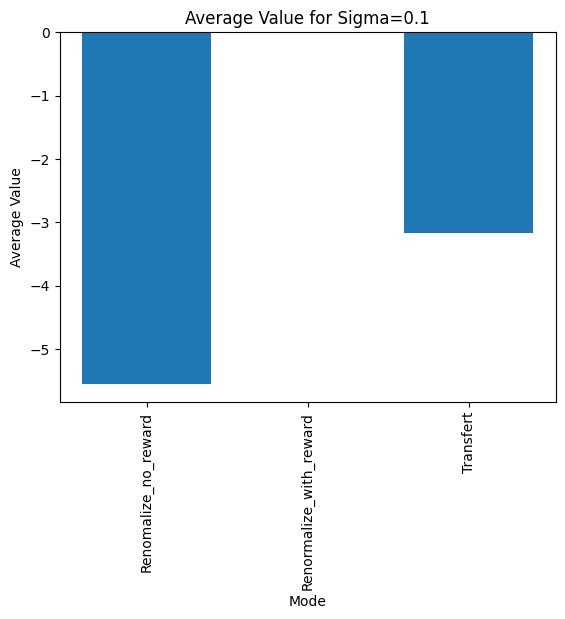

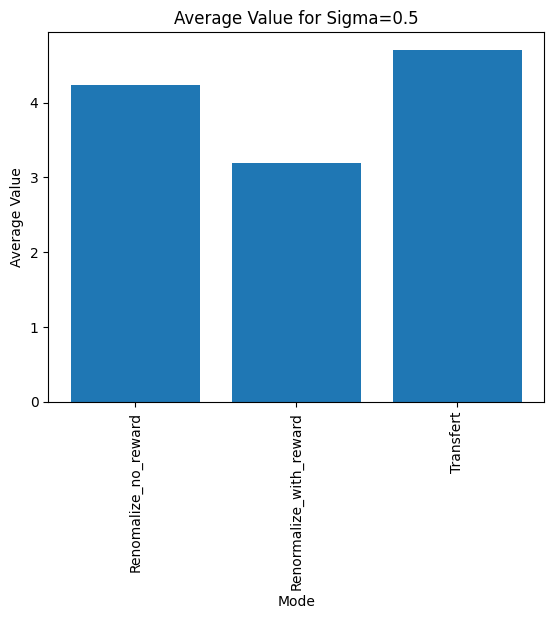

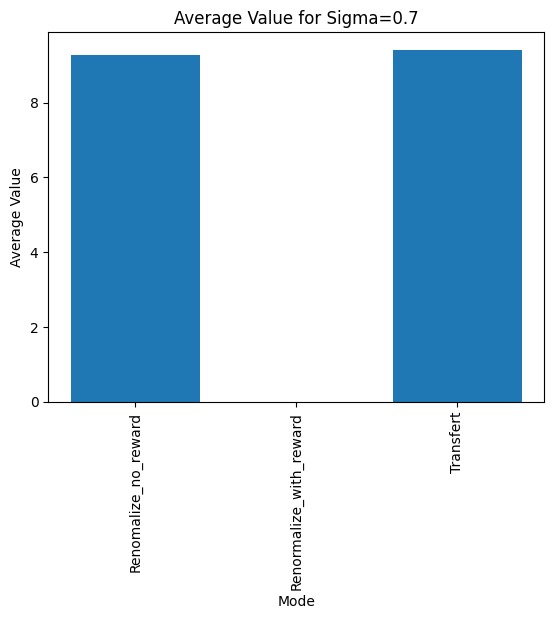

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "Sheets/Results.xlsx"

mode_list = ["Contribution_no_reward", "Contribution_with_reward", "Kernel_S_return", "Kernel_S_reward", "Orthogonal_bandit", "Penalty", "Permutations", "Permutations_ws", "Renomalize_no_reward", "Renormalize_with_reward", "Transfert"]

sigmas = [0.05, 0.1, 0.5, 0.7] # Sigma values trained on

for sigma in sigmas:
    optimal_value = []
    for mode in mode_list:
        df = pd.read_excel(file_path, mode)
        df = df[df["sigma"] == sigma]
        average_value = df["Value"].mean()
        optimal_value.append(average_value)
    plt.bar(mode_list, optimal_value)
    plt.xlabel("Mode")
    plt.ylabel("Average Value")
    plt.title(f"Average Value for Sigma={sigma}")
    plt.xticks(rotation=90)
    plt.savefig(f'Plots/Mode_plots/Sigma_{sigma}.png')
    plt.show()

We can see that only Kernel Search (with Basket criteria being Reward and not Expected Return), Renormalize and Transfert Methods are the best. (Penalty does NOT meet constraint)

Also, adding the reward in the state of the DRL could sometimes increase the results.

Finally, overall, Transfert is the best mode, even though it has actually seen the dataset the least.

# Barplot - Comparison between Gurobi and DRL 

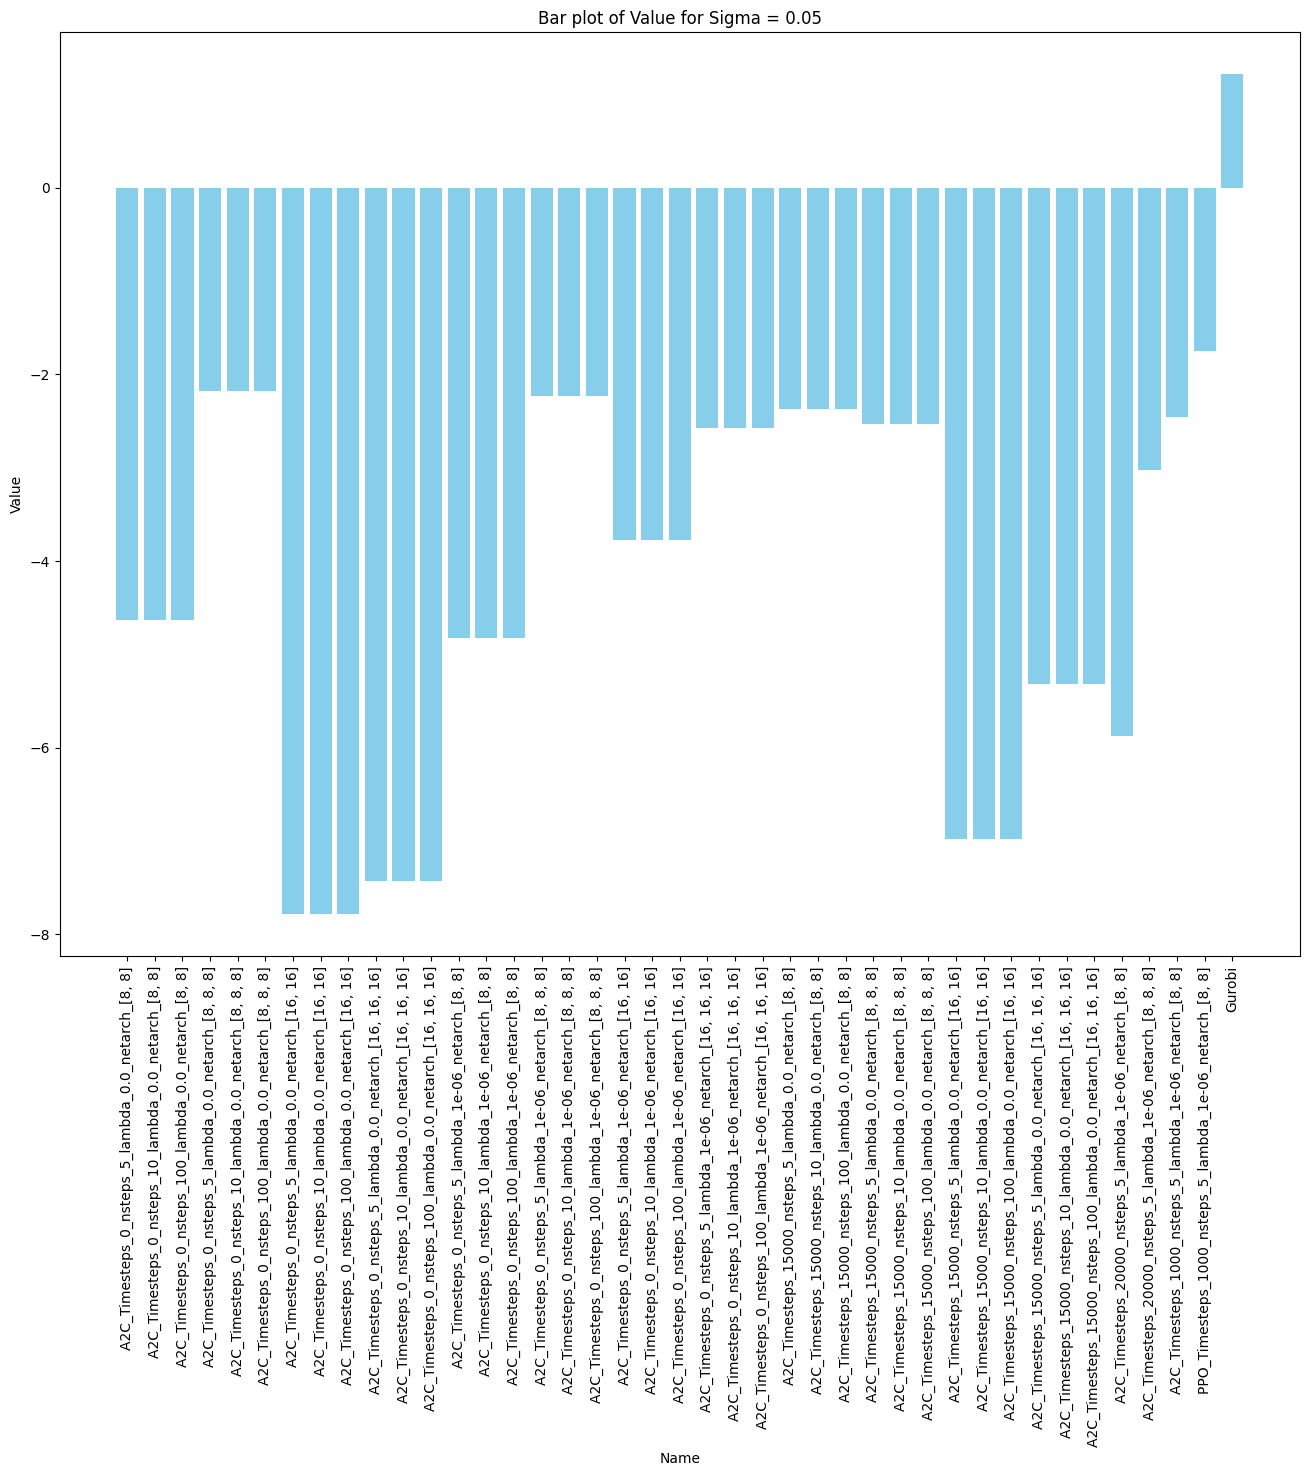

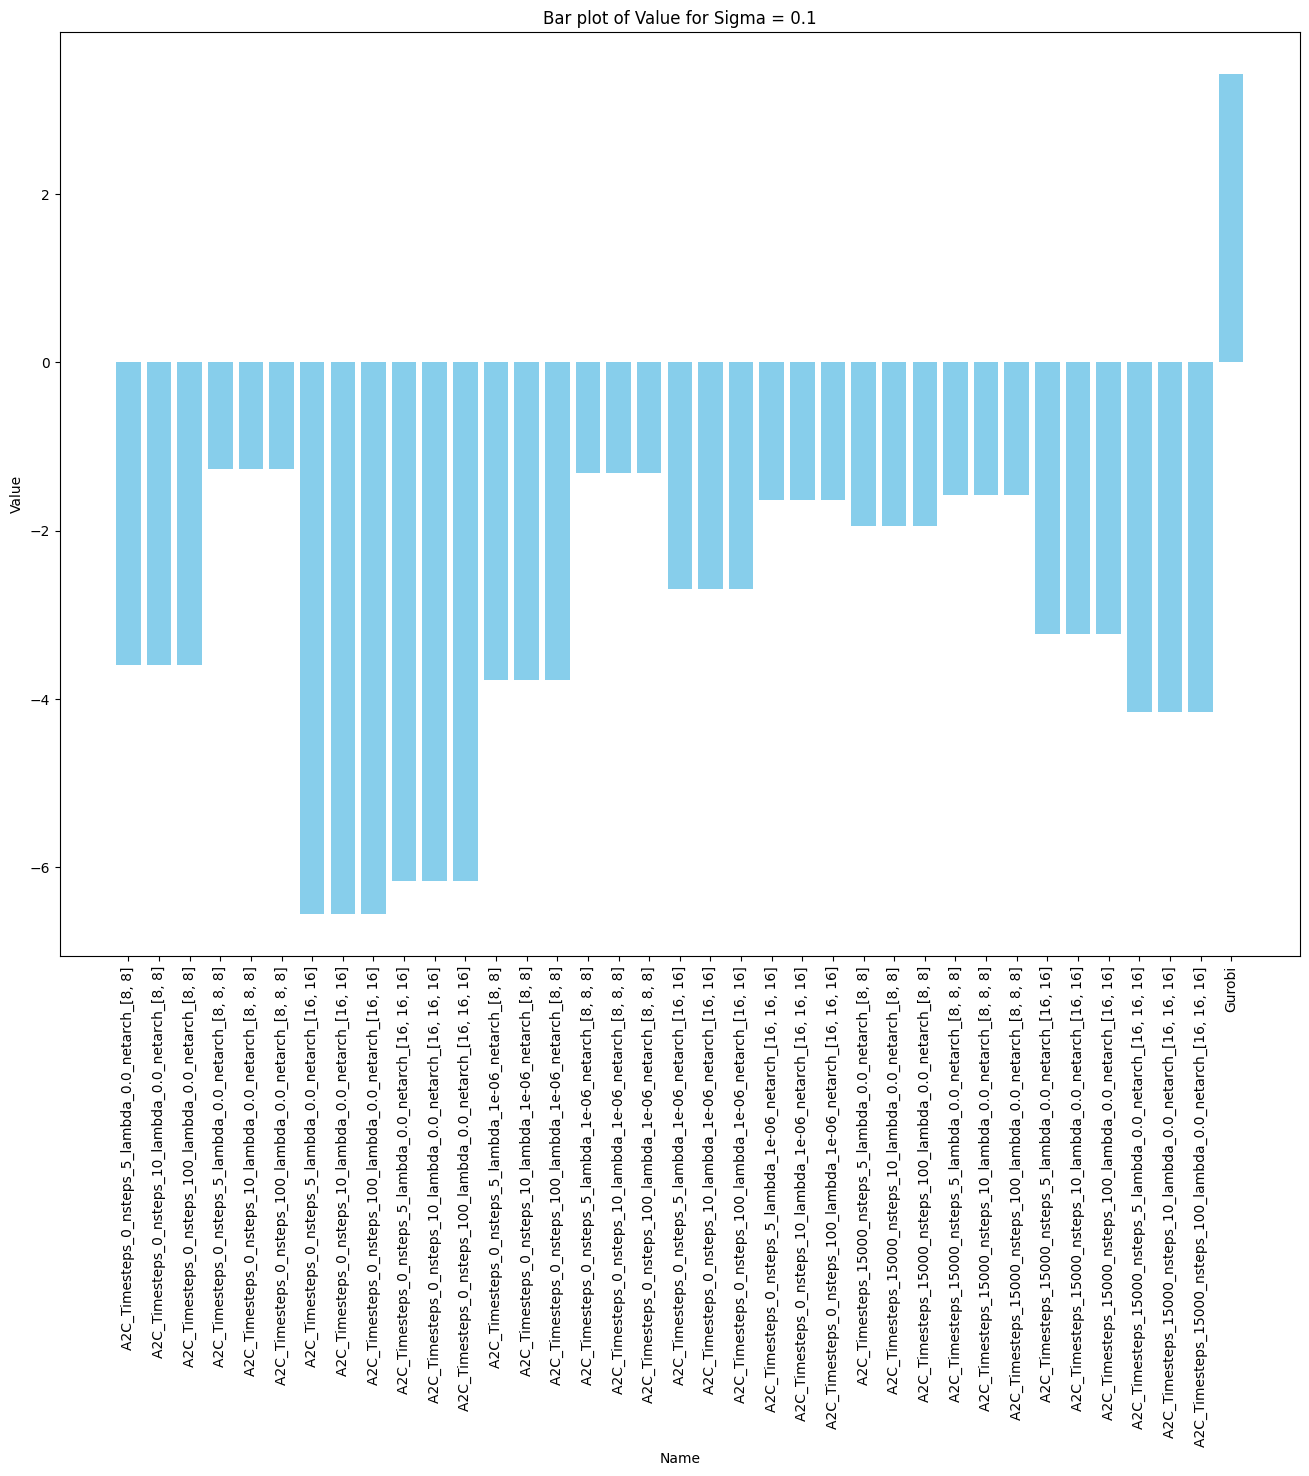

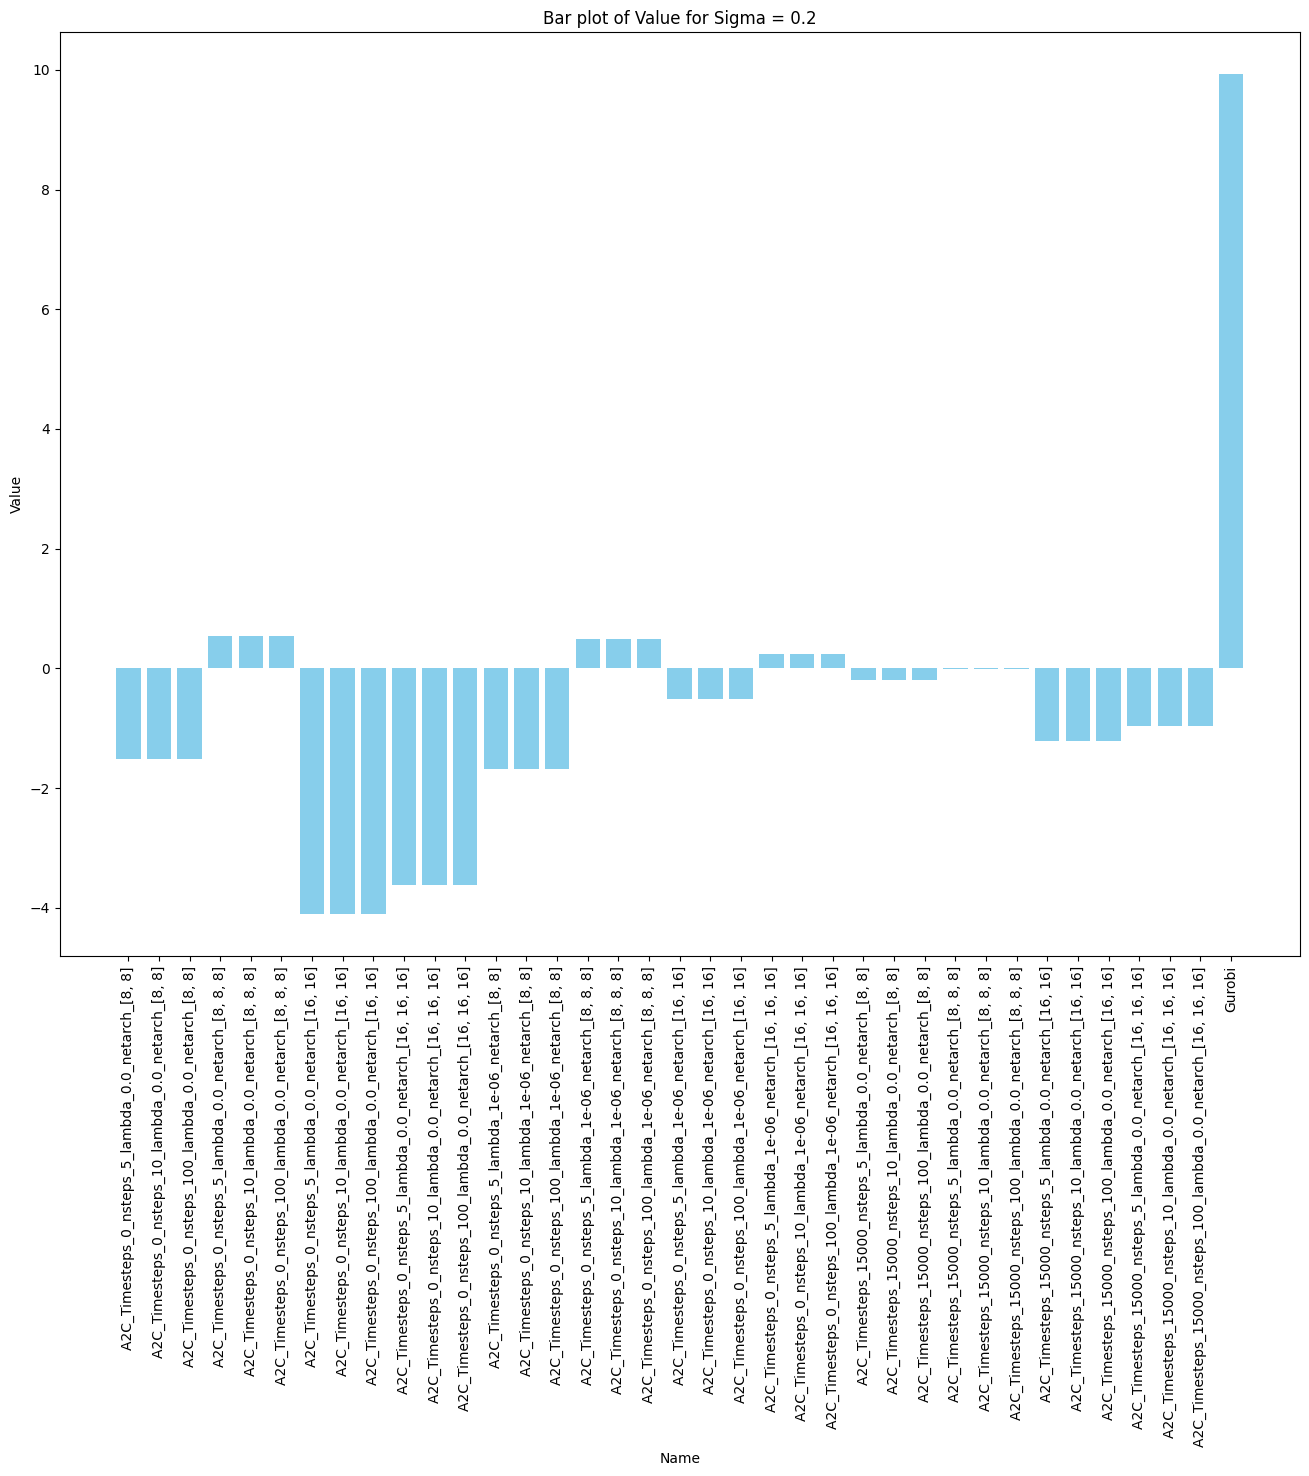

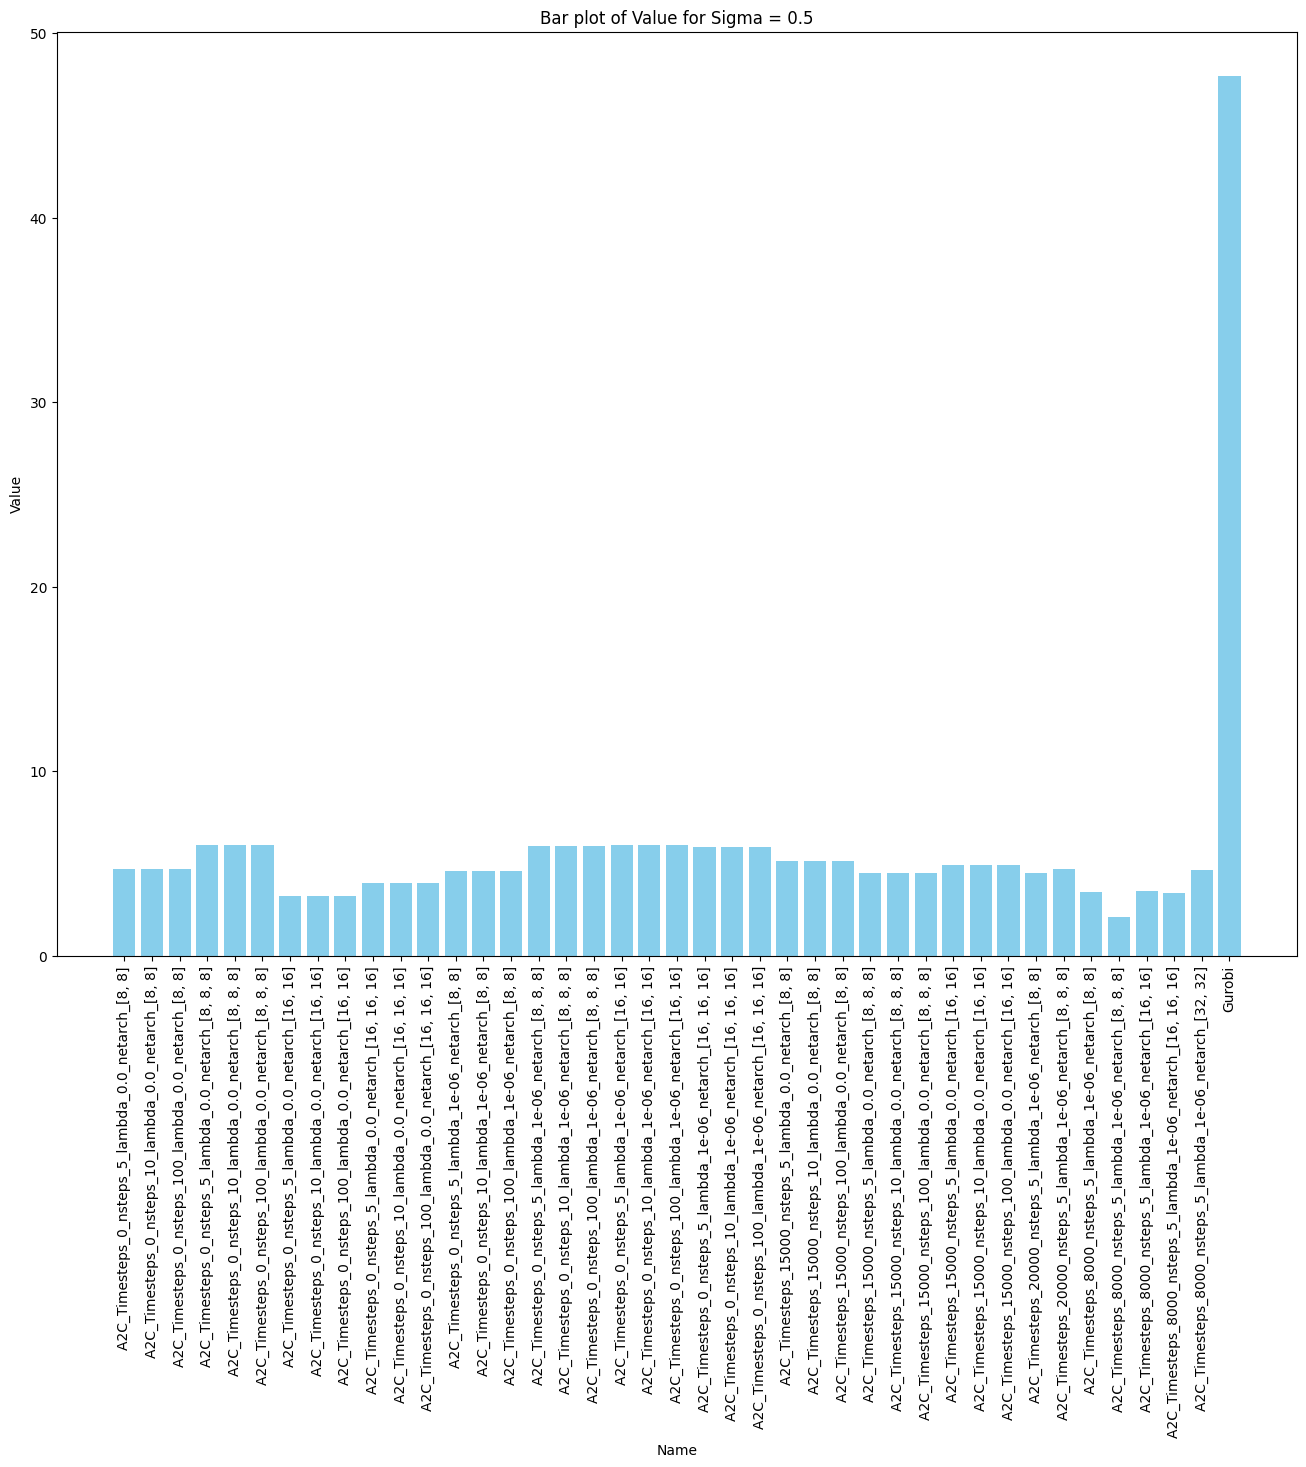

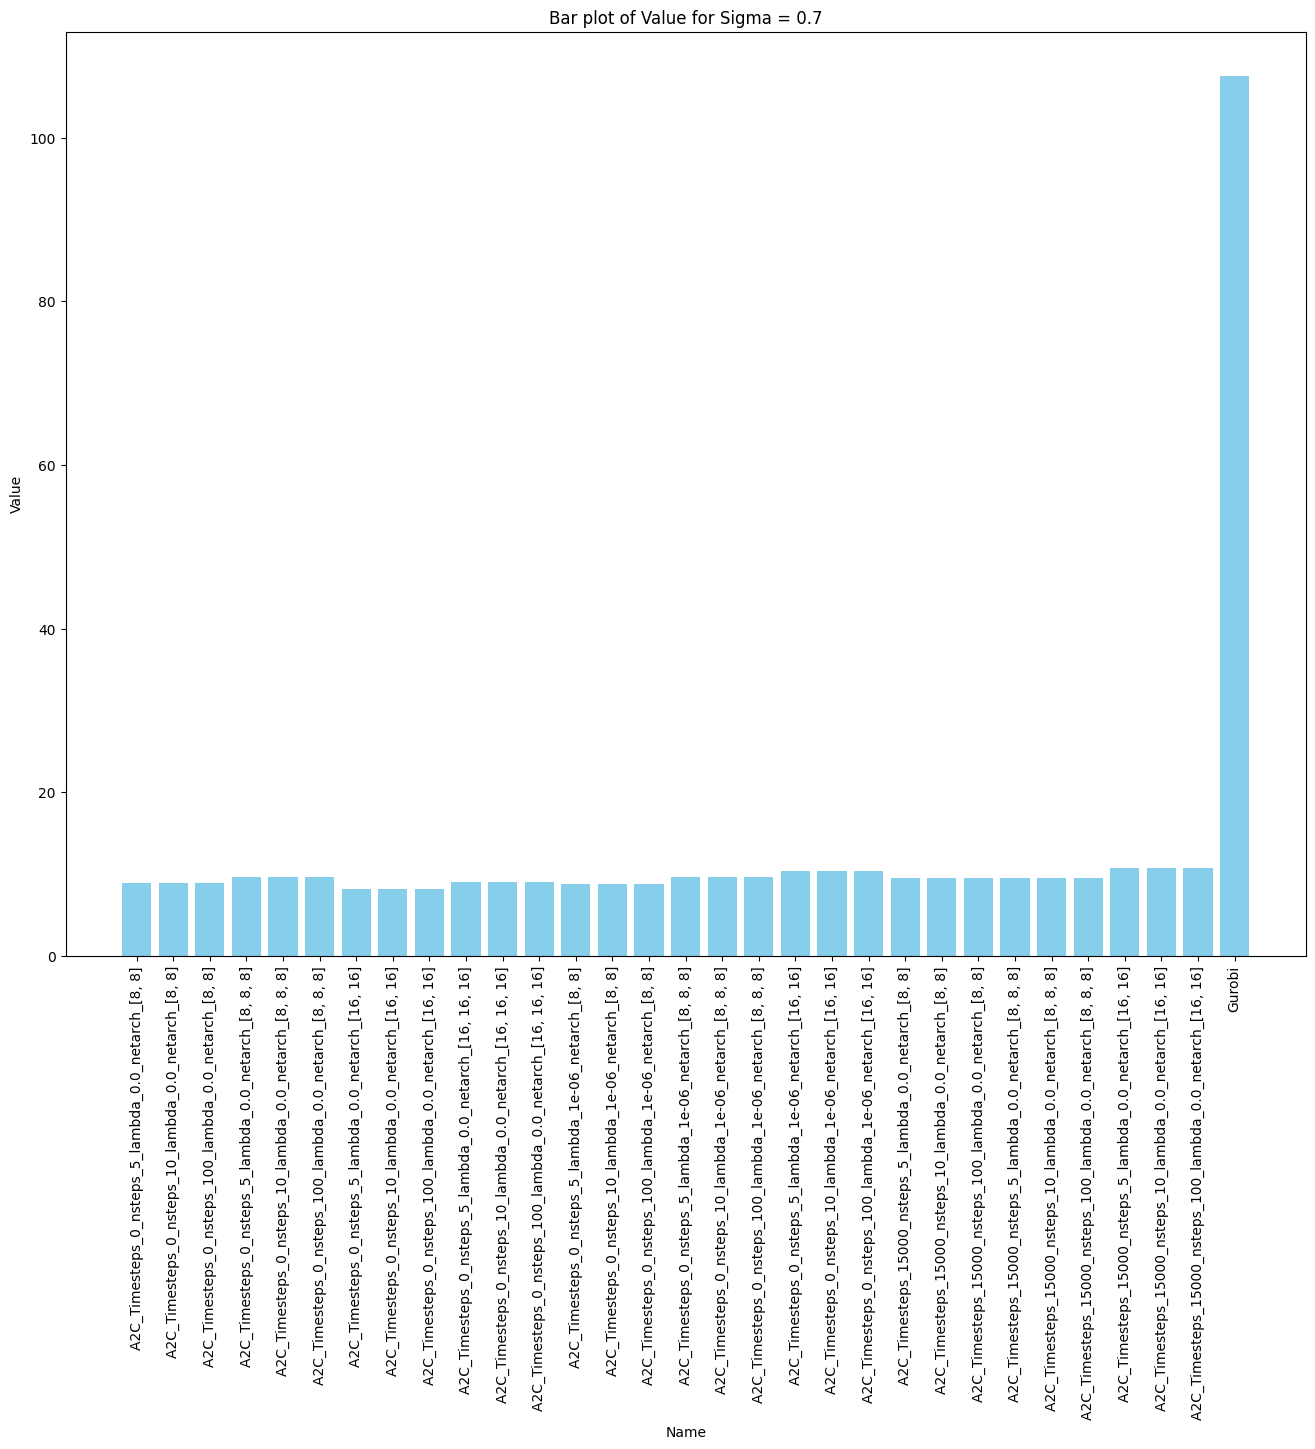

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'Sheets/Results.xlsx'    # DRL file
file_path2 = 'Sheets/Gurobi.xlsx'    # Gurobi file

df = pd.read_excel(file_path, sheet_name='Transfert')
df2 = pd.read_excel(file_path2, sheet_name='0,01_le')

df2 = df2[df2['Data'] == 'indtrack7.txt']

df["Name"] = df.apply(lambda row: f"{row['Model']}_Timesteps_{row['Timesteps']}_nsteps_{row['n_steps']}_lambda_{row['lambda']}_netarch_{row['net_arch']}", axis=1)

for sigma in [0.05, 0.1, 0.2, 0.5, 0.7]:
    df_tmp = df[df['sigma'] == sigma].copy()  
    
    df2_filtered = df2[(abs(df2["Sigma"] - sigma) < 0.0001) & (df2["Cardinality Constraint"] == 10)]
    
    if not df2_filtered.empty:
        optimal_value = df2_filtered["Optimal Value"].values[0]
        
        new_instance = pd.DataFrame({
            'Name': ["Gurobi"],
            'Value': [optimal_value]
        })
        
        # Ajouter cette nouvelle instance dans df_tmp
        df_tmp = pd.concat([df_tmp, new_instance], ignore_index=True)
        
        # Création du barplot
        fig = plt.figure(figsize=(16, 12))
        plt.bar(df_tmp['Name'], df_tmp['Value'], color='skyblue')
        
        plt.xticks(rotation=90)
        plt.xlabel('Name')
        plt.ylabel('Value')
        plt.title(f'Bar plot of Value for Sigma = {sigma}')
        plt.savefig(f'Plots/Gurobi_vs_DRL/Sigma_{sigma}.png')
        plt.show()


The DRL models were trained with the corresponding sigma value. But the hyperparameters choice were manually found when testing on sigma = 0.05. This means that for other values of sigma (such as 0.1, 0.5, 0.7), we will most likely need to try other Network Architecture, n_step, lambda for regularization, ...

We can indeed see that the results for sigma = 0.05 are decent. We can define a relative gap with respect to random weights $\frac{|Gurobi_{value} - DRL_{value}|}{|Gurobi_{value} - random_{value}|}$ (here, averaging 1000 random weights).

| sigma | Optimal Value for DRL | Optimal Value for Gurobi | Random Value obtained | Metric |
|-------|-----------------------|--------------------------|-----------------------|---------|
|0.01   | -2.1737                | 1.2165                    | -17.5449             | 18.07%  |
|0.1   | -1.268               | 3.4518                 | -15.5949             | 24.78%  |
|0.2   | 0.5434               | 9.9263                   | -11.6959             | 43.48%  |
|0.5   | 5.9776              | 47.7000                   | 0.0012            | 87.47%  |
|0.7   | 9.6005               | 107.5888                  | 7.7993           | 98.20%  |